# Higher rank batch dimensions on Fields

Our `Field` objects can optionally gain a batch dimension, which makes certain kinds of computations easier (e.g. propagation to multiple depths) without having to manually handle the extra dimensions all the time. A `Field` may have an arbitrary number of batch dimensions (including 0 in the simplest case for 2D field arrays), and all of the elements and functions in Chromatix will broadcast appropriately to handle these extra dimensions. However, this is still not flexible enough for every use case, such as propagation of multiple input fields to multiple depths or propagation of a field to multiple depths using functions that only support propagation to a single depth (e.g. scalable angular spectrum). In these cases, you can use `jax.vmap` to bridge the gap. This notebook will demonstrate how to use these (higher rank) batch dimensions, as well as how to customize the broadcasting for trickier cases than what the default behavior allows.

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, ScalarLike

import chromatix.functional as cx
from chromatix import Field
from chromatix.functional import objective_point_source

## Creating Fields with a single batch dimension for depth

The high level `Field.build` or the sources in `chromatix.functional`/`chromatix.elements` will produce `Field`s with no batch dimensions. Two exceptions are when creating a source with multiple planes like a point source defocused to multiple planes or when propagating a field to multiple distances. In those cases, Chromatix automatically adds one batch dimension to hold these depth planes. When you don't use functions that automatically add a batch dimension, Chromatix fields will be created without any batch dimension.

In [2]:
field = objective_point_source(
    (256, 256), 0.1, 0.532, jnp.linspace(-25, 25, num=5), 100.0, 1.33, 0.8
)
print(
    field.shape
)  # Created a Field with a batch dimension of size 5 for 5 different depth planes

(5, 256, 256)


## Creating Fields with more than one batch dimension using vmap

In order to add higher rank batch dimensions (i.e. more than one batch dimension), you'll have to use vmap. Here are two examples:

Field shape (2, 5, 256, 256)
Field spectrum wavelengths shape (2, 1)
Field spacing shape (2, 2)
[[0.1 0.1]
 [0.1 0.1]]


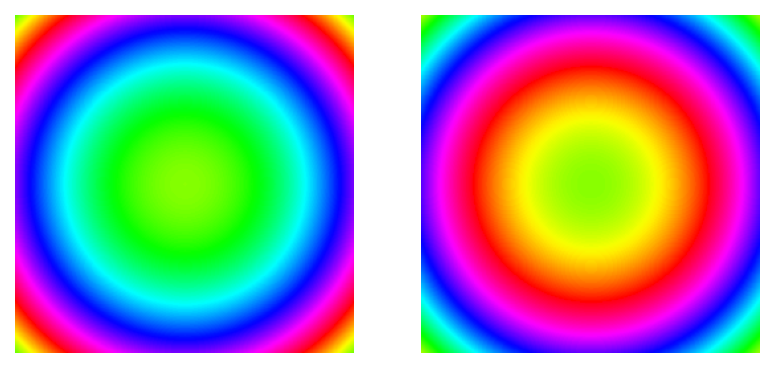

In [3]:
# This function takes an array of z values and is vmapped once,
# which means that the function accepts a 2D array of z values
# where each element of the batch can have a different set of z
# values to which the resulting field would be defocused.
@jax.vmap
def create_high_rank_field(zs: Array) -> Field:
    return objective_point_source((256, 256), 0.1, 0.532, zs, 100.0, 1.33, 0.8)


field = create_high_rank_field(
    jnp.stack([jnp.linspace(-25, 25, num=5), jnp.linspace(25, 50, num=5)])
)
print("Field shape", field.shape)
print("Field spectrum wavelengths shape", field.spectrum.wavelength.shape)
print("Field spacing shape", field.dx.shape)
print(field.dx)

fig, axes = plt.subplots(ncols=2, nrows=1, dpi=150)
ax = axes[0]
ax.imshow(field.phase[0, 0], cmap="hsv")
ax.axis("off")

ax = axes[1]
ax.imshow(field.phase[1, 0], cmap="hsv")
ax.axis("off")

plt.show()

In [4]:
# This function takes a spacing and is then vmapped twice,
# which means that the function accepts a 2D array of spacings
# where each element of the batch can have a different spacing.
# This is just an example, you could vmap over any other
# argument, such as wavelengths or depth planes.
@jax.vmap
@jax.vmap
def create_high_rank_field(dx: ScalarLike) -> Field:
    return Field.zeros((256, 256), dx, 0.532)


field = create_high_rank_field(jnp.array([[0.1, 0.1, 0.1], [0.2, 0.3, 0.4]]))
print("Field shape", field.shape)
print("Field spectrum wavelengths shape", field.spectrum.wavelength.shape)
print("Field spacing shape", field.dx.shape)
print(field.dx)

Field shape (2, 3, 256, 256)
Field spectrum wavelengths shape (2, 3, 1)
Field spacing shape (2, 3, 2)
[[[0.1 0.1]
  [0.1 0.1]
  [0.1 0.1]]

 [[0.2 0.2]
  [0.3 0.3]
  [0.4 0.4]]]


Note that this means you **will have spectrums and spacings with the same batch dimensions added on**!

## Passing batched Fields to vmapped functions to create higher ranked Fields

What if we wanted each element of the outer batch of 2 to be propagated to different z values? The propagation element/functions only accept a 1D array of z values. Luckily, `Field` supports being vmapped, with all its attributes such as `dx` or `spectrum` having their shapes appropriately rearranged dynamically. That means you can simply use `jax.vmap` on a function like so:

In [5]:
@partial(jax.vmap, in_axes=(None, 0))
def vmapped_system(field: Field, zs: Array) -> Field:
    field = cx.ff_lens(field, 100.0, 1.33, 0.8)
    field = cx.transfer_propagate(field, zs, 1.33, 0)
    return field


# Using a stack of z values to propagate each element of the batch
# to different z values using our vmapped function above
field = objective_point_source(
    (256, 256), 0.1, 0.532, jnp.linspace(-25, 25, num=5), 100.0, 1.33, 0.8
)
result = vmapped_system(
    field, jnp.stack([jnp.linspace(0, 25, num=5), jnp.linspace(25, 50, num=5)])
)

In [6]:
result.shape

(2, 5, 256, 256)

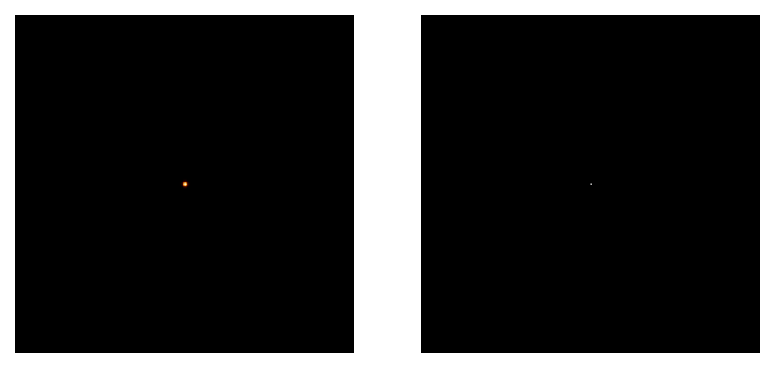

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, dpi=150)
ax = axes[0]
ax.imshow(result.intensity[0, 0], vmin=0, cmap="afmhot")
ax.axis("off")

ax = axes[1]
ax.imshow(result.intensity[1, 0], vmin=0, cmap="afmhot")
ax.axis("off")

plt.show()

And now we see that the propagation was different for each element of the outer batch!